In [379]:
# Import packages
import random as rd 
import numpy as np
from tqdm import tqdm # Enables loading bar
import pprint # Just for better print func
pp = pprint.PrettyPrinter()

In [380]:
# Parameters

population_size: int = 50
number_of_iterations: int = 10000
mutation_threshold: int = 998 # Should be between 0 - 1000 (0 means everything is mutated, 1000 means no mutation). Suggest to keep this number near 1000 to ensure convergence

In [381]:
# Init
n: int = population_size
cities: list[str] = ['Eindhoven', 'Maastricht', 'Amsterdam', 'Roermond', 'Memphes', 'Dublin', 'Berlin', 'Paris', 'Barcalona', 'Nice', \
                     'London', 'Madrid', 'Kiev']
coordinates: list[list[int, int]] = [
    [0, 0],
    [-10, 15],
    [10, -7],
    [-4, -10],
    [19, 11],
    [30, -9],
    [40, 20],
    [-12, 62],
    [30, 80],
    [10, 70],
    [-23, 0],
    [-30, 40],
    [20, 90]
]

# Init the population
population = []
cities_shuffeld = cities.copy()
for i in range(n):
    rd.shuffle(cities_shuffeld)
    population.append(cities_shuffeld)

In [382]:
# Reward func
def distance(origin: list, destination: list, coordinates: list, cities: list) -> float:

    coordinate_o = coordinates[cities.index(origin)]
    coordinate_d = coordinates[cities.index(destination)]
    
    return np.sqrt((coordinate_o[0] - coordinate_d[0]) ** 2 +
                   (coordinate_o[1] - coordinate_d[1]) ** 2)


def evaluate_route(route, cities, coordinates):
    total_distance = 0
    for i in range(len(route)):
        origin = route[i]
        destination = route[(i + 1) % len(route)]
        total_distance += distance(origin, destination, coordinates, cities)
    return total_distance

def evaluate_population(population, cities, coordinates):
    return [(evaluate_route(route, cities, coordinates)) for route in population]


In [383]:
# Mutation
def Mutation(population, n=len(cities), mutation_severity=10, threshold=50):
    for pop in range(len(population)):
        if rd.uniform(0, 1) * mutation_severity >= threshold:
            range_cities = n - 1
            indexing = rd.randint(0 , len(population)-1)
            gene1, gene2 = rd.randint(0, range_cities), rd.randint(0, range_cities)
            try:
                population[indexing][gene1], population[indexing][gene2] = population[indexing][gene2], population[indexing][gene1]
                assert len(population[indexing]) == len(cities)
            except:
                pass
    return population

In [384]:
# Cross-over
def procreate(parent1: tuple, parent2: tuple):

    cities_len = len(parent1)
    cut_points = sorted([rd.randint(0, cities_len), rd.randint(0, cities_len - 1)])
    if cut_points[0] == cut_points[1]:
        cut_points[1] = (cut_points[1] + 1) % cities_len

    child1 = ["0"] * cities_len
    child2 = ["0"] * cities_len
    copy1 = parent1[:]
    copy2 = parent2[:]

    for i in range(cut_points[0], cut_points[1]):
        gene = parent1[i]
        child1[i] = gene
        copy2.remove(gene)

        gene = parent2[i]
        child2[i] = gene
        copy1.remove(gene)

    for i in range(cities_len):
        if child1[i] == "0":
            child1[i] = copy2.pop(0)
        if child2[i] == "0":
            child2[i] = copy1.pop(0)

    return child1, child2

In [385]:
# Generate new population
reward_concat = []
def NewGen(population, reward, cities):
    reward_concat.append(reward)
    sorted_route = sorted(list(range(len(population))), key=lambda x: reward[x])
    sorted_genome = [population[i] for i in sorted_route]
    assert len(sorted_genome[0]) == len(sorted_genome[1])

    pi = np.array([reward[i] / sum(reward) for i in sorted_route])
    pi /= pi.sum()

    new_gen = []
    for i in range(len(population) - 2):
        new_gen.append(population[np.random.choice(len(population), p=pi)])

    cross1, cross2 = procreate(sorted_genome[0], sorted_genome[1])
    new_gen.append(cross1)
    new_gen.append(cross2)
    new_gen = Mutation(new_gen, mutation_severity=1000, threshold=mutation_threshold) # if mutation_severity * [0 - 1] >= threshold -> mutate
    #print(new_gen)
    return new_gen

In [386]:
# Run simulation 

for i in tqdm(range(number_of_iterations), desc="Progress"):
    reward = evaluate_population(population, cities, coordinates)
    population = NewGen(population, reward, cities)

Progress: 100%|██████████| 10000/10000 [00:09<00:00, 1051.36it/s]


Figure plotted for route: 
['Maastricht', 'London', 'Paris', 'Memphes', 'Kiev', 'Roermond', 'Barcalona', 'Berlin', 'Eindhoven', 'Nice', 'Amsterdam', 'Dublin', 'Madrid'] 
Route Length/Reward=389.7165724609135 


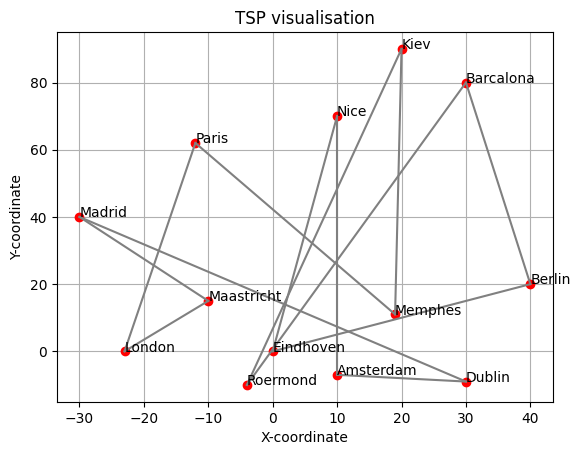

In [387]:
# TSP Visualization
import matplotlib.pyplot as plt

# Source and inspiration for this function: https://github.com/hassanzadehmahdi/Traveling-Salesman-Problem-using-Genetic-Algorithm
def drawMap(city: list, coordinates: list, answer: list, grid=False):
    # Create a dictionary mapping city names to their coordinates
    city_coordinates = dict(zip(city, coordinates))

    # Plot cities
    for j in city:
        coord = city_coordinates[j]
        # print(f'city {j}, has coordinate {coord}')
        plt.plot(coord[0], coord[1], "ro")
        plt.annotate(j, (coord[0], coord[1]))

    # Plot lines between cities based on the order in the answer
    for i in range(len(answer) - 1):
        first_city = answer[i]
        second_city = answer[i + 1]

        first_coord = city_coordinates[first_city]
        second_coord = city_coordinates[second_city]

        plt.plot([first_coord[0], second_coord[0]], [first_coord[1], second_coord[1]], "gray")

    # Plot line connecting the last city to the first city
    first_city = answer[0]
    last_city = answer[-1]

    first_coord = city_coordinates[first_city]
    last_coord = city_coordinates[last_city]

    plt.plot([first_coord[0], last_coord[0]], [first_coord[1], last_coord[1]], "gray")
    plt.title('TSP visualisation')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    if grid:
        plt.grid()
    plt.show()

print(f"Figure plotted for route: \n{population[np.argmin(reward)]} \nRoute Length/Reward={reward[np.argmin(reward)]} ")
drawMap(cities, coordinates, population[np.argmin(reward)], grid=True)


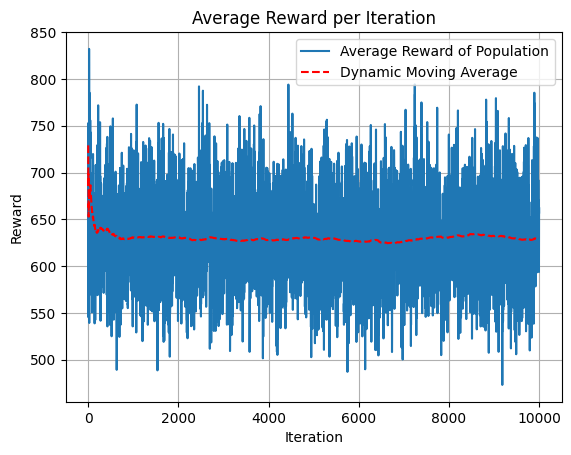

In [388]:
# Plot reward of itteration #1
def moving_average(data, window_size):
    """Compute moving average."""
    cumsum = np.cumsum(data)
    moving_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    return moving_avg

def plot_reward_func(concat_reward: list, initial_window_size=10, growth_factor=1.1, max_window_size=1000):
    avg_reward = [np.mean(row) for row in concat_reward]  # Calculate mean per row
    
    moving_avg = []
    window_size = initial_window_size
    
    for i in range(len(avg_reward)):
        if max_window_size is not None and window_size > max_window_size:
            window_size = max_window_size
        
        if i < window_size:
            moving_avg.append(np.mean(avg_reward[:i+1]))
        else:
            moving_avg.append(np.mean(avg_reward[i-window_size+1:i+1]))
            window_size = int(window_size * growth_factor)
    
    plt.plot(avg_reward, label='Average Reward of Population')
    plt.plot(range(len(moving_avg)), moving_avg, color='red', linestyle='dashed', 
             label="Dynamic Moving Average")
             #label=f'Moving Average (initial window={initial_window_size}, growth factor={growth_factor}, max window={max_window_size})')
    
    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    plt.title('Average Reward per Iteration')
    plt.grid(True)
    plt.legend()
    plt.show()


plot_reward_func(reward_concat, initial_window_size=10, growth_factor=50, max_window_size=2000)
    

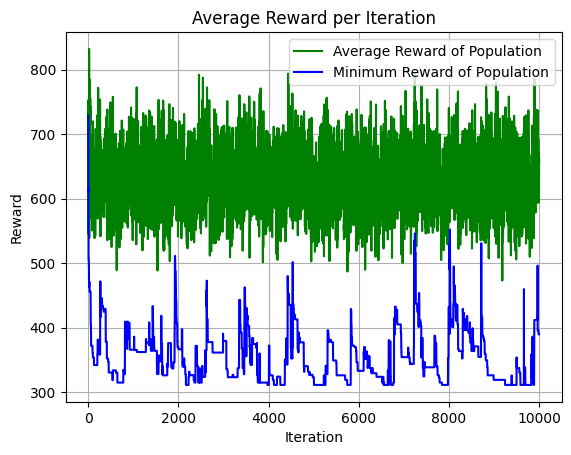

In [389]:
# Plot reward of itteration #2
def plot_reward_funcV2(concat_reward: list, initial_window_size=10, growth_factor=1.1, max_window_size=1000):
    avg_reward = [np.mean(row) for row in concat_reward]  # Calculate mean per row
    min_reward = [np.min(row) for row in concat_reward]  # Calculate minimum per row
    
    moving_avg = []
    window_size = initial_window_size
    
    # for i in range(len(avg_reward)):
    #     if max_window_size is not None and window_size > max_window_size:
    #         window_size = max_window_size
        
    #     if i < window_size:
    #         moving_avg.append(np.mean(avg_reward[:i+1]))
    #     else:
    #         moving_avg.append(np.mean(avg_reward[i-window_size+1:i+1]))
    #         window_size = int(window_size * growth_factor)
    
    plt.plot(avg_reward, label='Average Reward of Population', color='g')
    plt.plot(min_reward, label='Minimum Reward of Population', color='b')
    # plt.plot(range(len(moving_avg)), moving_avg, color='red', linestyle='dashed', 
    #          label="Dynamic Moving Average")
    
    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    plt.title('Average Reward per Iteration')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_reward_funcV2(reward_concat, initial_window_size=10, growth_factor=50, max_window_size=10000)